# Introduction Sequence to Sequence Models
Those are the models that are used on Machine translation. Different than the many-to-many approach, the sequence to sequence can output a sequence with size different than the input sequence.
This example we're going to learn about the encoder/decoder architecture (Without attention)

### Encoder / Decoder architecture.
The sequence to sequence model is divided on an encoder network that condense the input sequence into the hidden vector, and an decoder consume the hidden vector into another sequence.
![alt text](imgs/seq_to_seq_anim.gif "Sequence to Sequence")
The problem of this method is that we will condense a sequence of unknown size into a hidden vector of fixed size, which means some information will be lost. To mitigate this we can use the Attention mechanism.

### References
* https://towardsdatascience.com/transformers-141e32e69591
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* http://nlp.seas.harvard.edu/2018/04/03/attention.html
* https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
* https://github.com/harvardnlp/annotated-transformer
* https://arxiv.org/pdf/1902.10525.pdf
* https://distill.pub/2017/ctc/

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from utils_seq_to_seq import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Compute device:',device)

SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10
hidden_size = 256
teacher_forcing_ratio = 0.5

Compute device: cpu


In [2]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


### Load the dataset

In [3]:
print(normalizeString('Hi hello world! What\'s your name?'))
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

hi hello world ! what s your name ?
Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['t es un mec marrant .', 'you re a funny man .']


### Encoder

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # The embedding layer will learn a word2vec with your training data
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training Functions

In [6]:
def train(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [7]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang, device)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Evaluate Functions

In [8]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, device)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Train and Evaluate

21m 31s (- 301m 26s) (5000 6%) 2.9262
24m 51s (- 161m 32s) (10000 13%) 2.3515
27m 39s (- 110m 37s) (15000 20%) 2.0416
30m 27s (- 83m 45s) (20000 26%) 1.7610
33m 16s (- 66m 33s) (25000 33%) 1.5803
36m 6s (- 54m 9s) (30000 40%) 1.3980
38m 55s (- 44m 29s) (35000 46%) 1.2283
41m 45s (- 36m 32s) (40000 53%) 1.0885
44m 35s (- 29m 43s) (45000 60%) 0.9856
47m 24s (- 23m 42s) (50000 66%) 0.8804
50m 14s (- 18m 16s) (55000 73%) 0.7874
53m 5s (- 13m 16s) (60000 80%) 0.7125
55m 57s (- 8m 36s) (65000 86%) 0.6549
58m 47s (- 4m 11s) (70000 93%) 0.5686
61m 38s (- 0m 0s) (75000 100%) 0.5217
> je suis fourbu .
= i m exhausted .
< i am exhausted . <EOS>

> tu es fort sage .
= you re very wise .
< you re very wise . <EOS>

> je suis un agent .
= i m an agent .
< i am a stranger . <EOS>

> je suis fier de mon pere .
= i m proud of my father .
< i am proud of my father . <EOS>

> il aime beaucoup ce genre de musique .
= he is fond of this kind of music .
< he is fond of this kind of music . <EOS>

> nous rej

<Figure size 432x288 with 0 Axes>

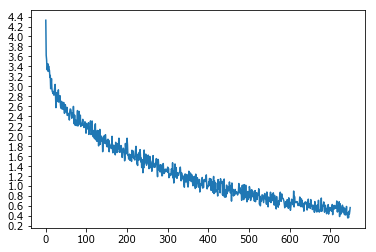

In [9]:
# Instantiate Encoder and Decoder Networks
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train
trainIters(encoder1, decoder1, 75000, print_every=5000)

# Evaluate
evaluateRandomly(encoder1, decoder1)